# 模型选择、欠拟合和过拟合

训练误差和泛化误差

* 训练误差：模型在训练数据上的误差

* 泛化误差：模型在新数据上的误差

* 机器学习的目标是减少泛化误差

模型选择

* 验证数据集：用于评估模型性能的数据集

K折交叉验证

* 当数据集较小时，使用K折交叉验证来评估模型性能

* 将数据集分成K个部分，每次选择K-1个部分作为训练集，剩下的1个部分作为验证集，进行K次训练和验证，最后取K次验证误差的平均值作为模型的性能指标

欠拟合和过拟合

* 欠拟合：模型过于简单，无法很好地拟合训练数据

* 过拟合：模型过于复杂，在训练数据上表现很好，但在新数据上表现较差

* 受多种因素影响：模型复杂度和训练数据集大小等

模型复杂度

训练数据集大小

多项式函数拟合实验

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] + true_w[2] * poly_features[:, 2] + true_b
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [4]:
features[:2], poly_features[:2], labels[:2]

(
 [[1.1630785]
  [0.4838046]]
 <NDArray 2x1 @cpu(0)>,
 
 [[1.1630785  1.3527517  1.5733565 ]
  [0.4838046  0.2340669  0.11324265]]
 <NDArray 2x3 @cpu(0)>,
 
 [10.534649  5.530093]
 <NDArray 2 @cpu(0)>)

定义、训练和测试模型

In [6]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)
    d2l.plt.show()

In [10]:
num_epochs = 100
loss=gloss.L2Loss() # 均方误差损失函数
def fit_and_plot(train_features, test_features, train_labels, test_labels): # 输入：训练特征、测试特征、训练标签、测试标签
    net = nn.Sequential() # 添加一个线性层
    net.add(nn.Dense(1)) # 输出维度为1的全连接层
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(), 'bias:', net[0].bias.data().asnumpy())

三项多项式函数拟合（正常）

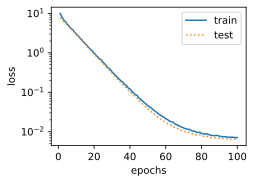

weight: [[ 1.1698747 -3.392285   5.606889 ]] bias: [4.985464]


In [11]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

线性函数拟合（欠拟合）

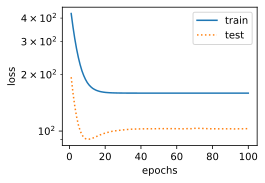

weight: [[22.668919]] bias: [-0.6552248]


In [12]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:]) 

训练样本不足（过拟合）

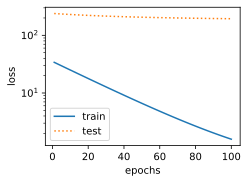

weight: [[3.6826632]] bias: [3.7370243]


In [13]:
fit_and_plot(features[0:2, :], features[n_train:, :], labels[0:2], labels[n_train:])

使用三阶多项式模型拟合线性数据会导致过拟合、泛化能力差、对噪声敏感等问题。对于线性数据，应优先选择线性模型，以确保模型的简洁性和泛化能力。

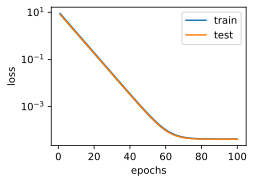

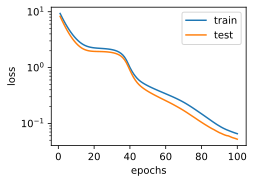

In [14]:
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import nn, data as gdata, loss as gloss
import matplotlib.pyplot as plt

# 生成线性数据
n_train = 100
n_test = 50
true_w = nd.array([2])
true_b = 4.2
features = nd.random.normal(scale=1, shape=(n_train + n_test, 1))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

# 定义线性模型
net_linear = nn.Sequential()
net_linear.add(nn.Dense(1))
net_linear.initialize(init.Normal(sigma=0.01))

# 定义三阶多项式模型
net_poly = nn.Sequential()
net_poly.add(nn.Dense(64, activation='relu'),  # 隐藏层
             nn.Dense(64, activation='relu'),  # 隐藏层
             nn.Dense(1))                      # 输出层
net_poly.initialize(init.Normal(sigma=0.01))

# 训练和测试函数
def fit_and_plot(net, train_features, test_features, train_labels, test_labels):
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(100):
        for X, y in train_iter:
            with autograd.record():
                l = gloss.L2Loss()(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(gloss.L2Loss()(net(train_features), train_labels).mean().asscalar())
        test_ls.append(gloss.L2Loss()(net(test_features), test_labels).mean().asscalar())
    plt.semilogy(range(1, 101), train_ls, label='train')
    plt.semilogy(range(1, 101), test_ls, label='test')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

# 使用线性模型拟合
fit_and_plot(net_linear, features[:n_train], features[n_train:], labels[:n_train], labels[n_train:])

# 使用三阶多项式模型拟合
fit_and_plot(net_poly, features[:n_train], features[n_train:], labels[:n_train], labels[n_train:])